In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import numpy as np
import matplotlib
matplotlib.rcParams["image.interpolation"] = 'nearest'
import matplotlib.pyplot as plt


from glob import glob
from tqdm import tqdm
from tifffile import imread
from csbdeep.utils import Path, normalize

from stardist import fill_label_holes, random_label_cmap, calculate_extents, gputools_available
from stardist.matching import matching, matching_dataset
from stardist.models import Config2D, StarDist2D, StarDistData2D
import json

In [2]:
def load_model(model_path: str) -> StarDist2D:
    # Load StarDist model weights, configurations, and thresholds
    with open(model_path + '\\config.json', 'r') as f:
        config = json.load(f)
    with open(model_path + '\\thresholds.json', 'r') as f:
        thresh = json.load(f)
    model = StarDist2D(config=Config2D(**config), basedir=model_path, name='offshoot_model')
    model.thresholds = thresh
    print('Overriding defaults:', model.thresholds, '\n')
    model.load_weights(model_path + '\\weights_best.h5')
    return model

In [3]:
model_v5 = load_model(r'\\10.99.68.178\andreex\data\monkey fetus\gestational 40\stardist_models\monkey_tile_trained_v5')

model_best_new = load_model(r"\\10.99.68.178\andreex\data\Stardist\models\monkey_ft_11_03_2023_lr_0.001_epochs_400_pt_40")

base_model.py (149): output path for model already exists, files may be overwritten: \\10.99.68.178\andreex\data\monkey fetus\gestational 40\stardist_models\monkey_tile_trained_v5\offshoot_model


Using default values: prob_thresh=0.5, nms_thresh=0.4.
Overriding defaults: Thresholds(prob=0.4691482484340668, nms=0.3) 



base_model.py (149): output path for model already exists, files may be overwritten: \\10.99.68.178\andreex\data\Stardist\models\monkey_ft_11_03_2023_lr_0.001_epochs_400_pt_40\offshoot_model


Using default values: prob_thresh=0.5, nms_thresh=0.4.
Overriding defaults: Thresholds(prob=0.5742374622613553, nms=0.3) 



pretrain_and_monkey_f model was trained on all fallopian tube tiles we have right now minus the last tile. You should only validate its performance of the very last tile in X because it was trained on all the other tiles in X. I was just too lazy to change my code when I plot it, but this is an important note.

In [12]:
# Get tiles and labels
X = sorted(glob(r'\\10.99.68.178\andreex\data\monkey fetus\gestational 40\1024tiles\new_tiles_11_3\tiles512\*.tif'))
#Y = sorted(glob(r'\\10.99.68.178\andreex\data\Ashleigh fallopian tube\fallopian tubes\AJER376\stardist_training_tiles512\stardist_segmented_jsons\qupath\ground_truth\masks\*.tif'))

X = list(map(imread,X))
# Y = list(map(imread,Y))

In [13]:
X = [x/255 for x in X]  # no norm, just divide by 255 to get into (0,1) range
# Y = [fill_label_holes(y) for y in tqdm(Y)]  # fills holes in annotations if there are any

Y_pred_model_v5 = [model_v5.predict_instances(x, n_tiles=model_best_new._guess_n_tiles(x), show_tile_progress=False)[0]
              for x in tqdm(X)]

Y_pred_model_best_new = [model_best_new.predict_instances(x, n_tiles=model_best_new._guess_n_tiles(x), show_tile_progress=False)[0]
              for x in tqdm(X)]

100%|██████████| 9/9 [00:01<00:00,  8.26it/s]


In [14]:
Y_pred_model_v5[1].shape

(512, 512)

In [15]:
np.random.seed(42)
lbl_cmap = random_label_cmap()

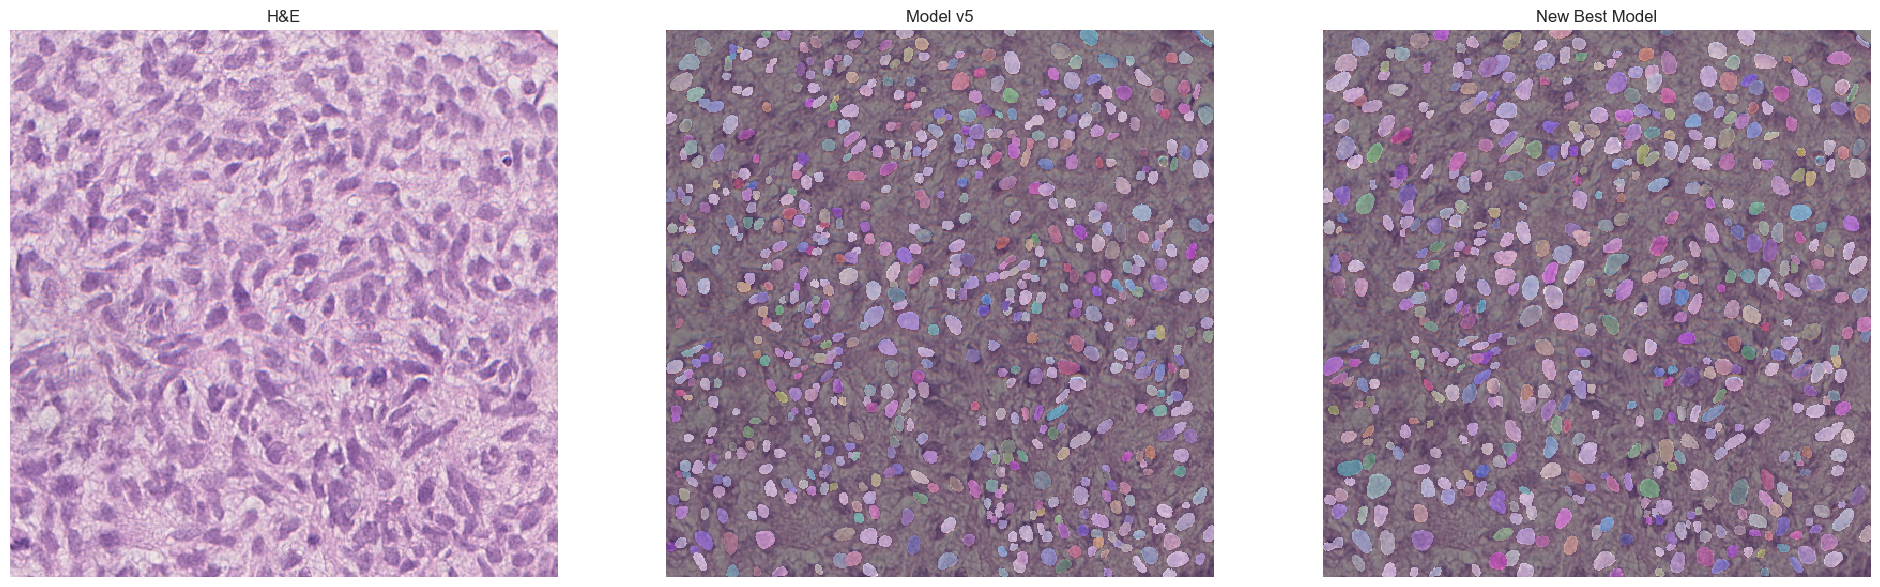

In [32]:
ind = 5

tile = X[ind]

fig, ax = plt.subplots(1,3,figsize = (24, 8))
ax[0].imshow(tile)
ax[0].axis('off')
ax[0].set_title('H&E')

ax[1].imshow(tile)
ax[1].imshow(Y_pred_model_v5[ind], cmap=lbl_cmap, alpha=0.4)
ax[1].axis('off')
ax[1].set_title('Model v5')

ax[2].imshow(tile)
ax[2].imshow(Y_pred_model_best_new[ind], cmap=lbl_cmap, alpha=0.4)
ax[2].axis('off')
ax[2].set_title('New Best Model')
plt.show()

In [9]:
Y_val = [Y[-1]]
Y_pred_m = [Y_pred_pretrain_and_monkey[-1]]
Y_pred_mf = [Y_pretrain_and_monkey_f[-1]]

taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

Y_nm = sorted(glob(r'\\10.99.68.178\andreex\data\Ashleigh fallopian tube\fallopian tubes\AJER376\stardist_training_tiles512\stardist_segmented_jsons\qupath\ground_truth\masks\*.tif'))

Y_nm = [Y_nm[-1]]

In [10]:
from scoring_for_donald import TileSetScorer

scores_mf = TileSetScorer(Y_nm, Y_val, Y_pred_mf, taus)

scoring_for_donald.py (62): The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


In [11]:
scores_mf.score_set()

scoring_for_donald.py (62): The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


,Image,Tau,IoU,TP,FP,FN,Precision,Recall,Avg Precision,F1 Score,Seg Quality,Pan Quality
0,\\10.99.68.178\andreex\data\Ashleigh fallopian...,0.1,0.66602,145,2,36,0.986395,0.801105,0.792350,0.884146,0.722266,0.638589
1,\\10.99.68.178\andreex\data\Ashleigh fallopian...,0.2,0.66602,145,2,36,0.986395,0.801105,0.792350,0.884146,0.722266,0.638589
2,\\10.99.68.178\andreex\data\Ashleigh fallopian...,0.3,0.66602,144,3,37,0.979592,0.795580,0.782609,0.878049,0.725685,0.637187
3,\\10.99.68.178\andreex\data\Ashleigh fallopian...,0.4,0.66602,142,5,39,0.965986,0.784530,0.763441,0.865854,0.730631,0.632620
4,\\10.99.68.178\andreex\data\Ashleigh fallopian...,0.5,0.66602,137,10,43,0.931973,0.761111,0.721053,0.837920,0.740724,0.620668
5,\\10.99.68.178\andreex\data\Ashleigh fallopian...,0.6,0.66602,123,24,57,0.836735,0.683333,0.602941,0.752294,0.760547,0.572154
6,\\10.99.68.178\andreex\data\Ashleigh fallopian...,0.7,0.66602,91,56,89,0.619048,0.505556,0.385593,0.556575,0.797385,0.443805
7,\\10.99.68.178\andreex\data\Ashleigh fallopian...,0.8,0.66602,44,103,136,0.299320,0.244444,0.155477,0.269113,0.841772,0.226532
8,\\10.99.68.178\andreex\data\Ashleigh fallopian...,0.9,0.66602,3,144,177,0.020408,0.016667,0.009259,0.018349,0.903578,0.016579
